# Feature Selection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tools.feature_format import featureFormat

# For importance_plotter
import matplotlib.patches as mpatches
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

### Get the data already preprocessed in [outlier_removal](outlier_removal.ipynb) and [imputing_data](imputing_data.ipynb)

In [2]:
import pickle

with open('imputer_dicts.pkl', 'rb') as f:
    imputer_dicts = pickle.load(f)

mean_data_dict = imputer_dicts['mean']

# Start with all features except: 'email_address'
all_feature_names = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',\
'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi',\
'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances',\
'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income',\
'long_term_incentive', 'from_poi_to_this_person']

mean_data = featureFormat(mean_data_dict, all_feature_names)
labels, features = mean_data[:,0], mean_data[:, 1:]

### Make a pipeline

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

pipe = Pipeline([
                 ('scaler', StandardScaler()),
                 ('polynomials', PolynomialFeatures(2)),
                 ('feature_selr', SelectFromModel(
                                                 ExtraTreesClassifier(
                                                     random_state=2,
                                                     class_weight='balanced'), 
                                                 threshold='1.5*mean'))
                ])

### Select features to use based on their importance as estimated by an ExtraTreesClassifier

In [4]:
def importance_plotter(fitted_pipe, feature_names):
    """
    Makes a bar graph of feature importances based on ExtraTreesClassifier.
    Returns a list with the features selected to be above the importance mean.
    """

    sel = pipe.named_steps['feature_selr']
    poly = pipe.named_steps['polynomials']
    forest = sel.estimator_
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    
    indices = np.argsort(importances)[::-1]
    
    feature_names = poly.get_feature_names(feature_names)
    name_array = np.array(feature_names)
    sorted_names = name_array[indices]
    sorted_importances = importances[indices]
    sorted_std = std[indices]
    mask = np.where(sorted_importances > 0)
    crop_names = sorted_names[mask]
    crop_importances = sorted_importances[mask]
    crop_std = sorted_std[mask]
    
    selected_indices = sel.get_support()
    selected_names = name_array[selected_indices]
    
    ind = len(crop_importances)

    # Plot the feature importances and which were selected
    plt.close('all')
    fig = plt.figure(1, figsize=(20, 14), tight_layout=True)
    ax = fig.gca(title='Feature selection based on ExtraTreesClassifier importances',
                 xlabel='Feature name',
                 xlim=[-1, ind],
                 xticks=range(ind),
                 ylabel='Importance')
    bar_list = ax.bar(range(ind), crop_importances,
                      color='b', yerr=crop_std, align='center')
    ax.set_xticklabels(crop_names, rotation='45', ha='right')
    
    # color feature names not from polynomials in red
    xlabs = ax.xaxis.get_ticklabels()
    for text in xlabs:
        if text.get_text() in all_feature_names:
            text.set_color('red')
    
    # color selected features red
    for i, name in enumerate(sorted_names):
        if name in selected_names:
            bar_list[i].set_color('r')
    
    # create custom legend
    red_patch = mpatches.Patch(color='red', label='Features selected')
    blue_patch = mpatches.Patch(color='blue', label='Features not selected')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

    return list(selected_names)

/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


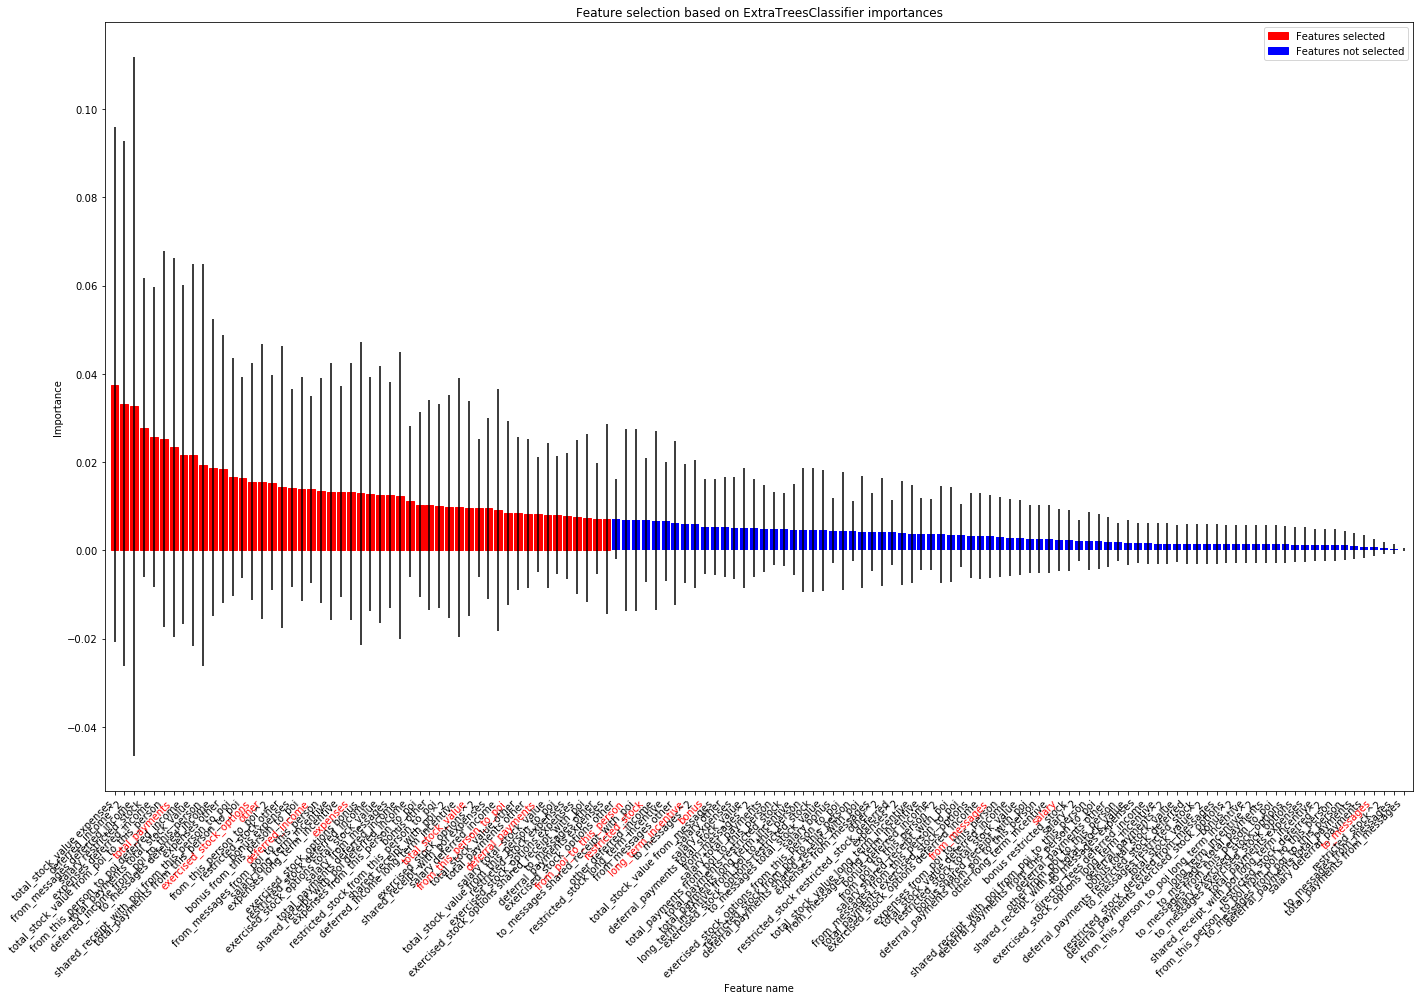

In [5]:
pipe.fit(features, labels)
selected_names = importance_plotter(pipe, all_feature_names[1:])